In [3]:
! pip install matplotlib

  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
Using cached contourpy-1.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (306 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.51.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [4]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models

In [7]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
NUM_OF_CLASSES=4

## Dataloaders + Datasets + preprocessing

Note: AlexNet accepts images of size 227x227

In [9]:
# Resize the image and do a center crop, and store them on a tensor
import torchvision.transforms as transforms
img_size = (227, 227)
batch_size=32
train_data_dir = '/home/jovyan/BrainTumour/Training'
test_data_dir = '/home/jovyan/BrainTumour/Testing'

#preprocessing : standardizing the sizes 
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

## Trainer code

In [12]:
def train(model, train_loader, test_loader,training_name,saved_weights_dir, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'saved weights to {savedDir}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [13]:
#accuracy graph
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [14]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Tester code

In [15]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()    
    # recreate test
    test_losses = []
    test_accuracies = []
    
    
    for epoch in range(epochs):
        print(epoch)
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')    
    return test_losses, test_accuracies

In [16]:
def plot_test_acc(test_acc):
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(' Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [17]:
def plot_test_loss(test_loss):
    
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Model Definition : Using transfer learning - original pre trained AlexNet convolution for feature extraction

In [18]:
# we will be replacing the fc classification layers of the original AlexNet with our own implementation
class myAlexNetclassifier(nn.Module):
    def __init__(self, nsize,dropout=0.5):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nsize, 256)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256,NUM_OF_CLASSES)
        

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out= self.batch_norm(out)
        out = self.dropout(out)
        out= self.fc2(out)
        return out


In [19]:
# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

#  freeze the parameters of the pre-trained model
for param in alexnet.parameters():
    param.requires_grad = False


num_features = alexnet.classifier[1].in_features #make sure the number of output features before fc1 matches our input
original_classifier = alexnet.classifier #we save the original/edited original classifier, just for the case we want to use it later

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model 1

In [53]:

my_alexnet_classifier =myAlexNetclassifier(num_features)
alexnet.classifier = my_alexnet_classifier

print(alexnet)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): myAlexNetclassifier(
    (fc1): Linear(in_features=9216, out_features=256, bias=True)
    (relu): ReLU()
    (batch_

In [54]:
model=alexnet.to(device)
training_name="AlexNetPretrained1"
saved_weights_dir="/home/jovyan/AlexNet_pretrained_weights"
max_epochs=15

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.15625
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.4270833333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.5078125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.55625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.578125
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.6116071428571429
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.62109375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.6284722222222222
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.640625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.6477272727272727
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.6510416666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.6514423076923077
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.6629464285714286
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.66875
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.67382

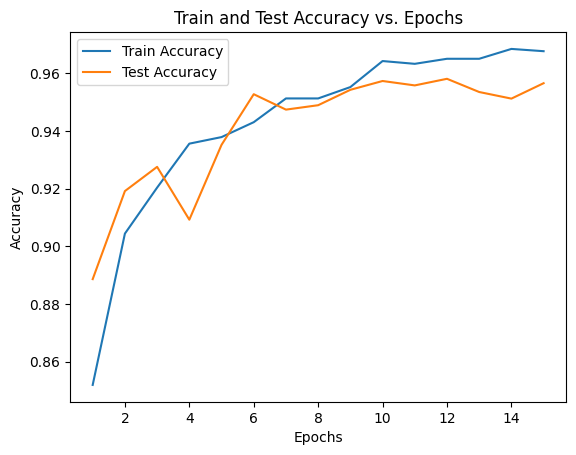

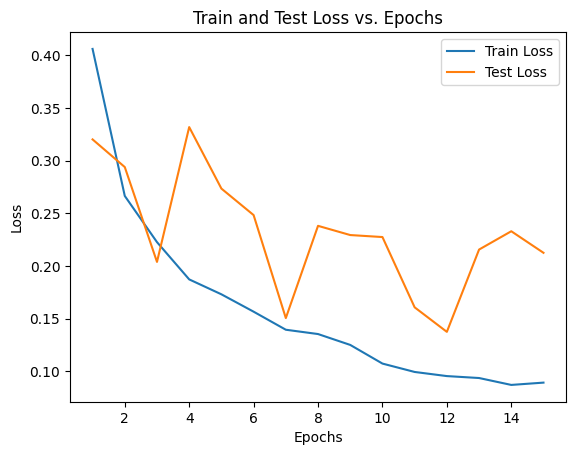

In [55]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)
# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.3201, Test accuracy: 0.8886
1
--- Epoch 2/15: Test loss: 0.2939, Test accuracy: 0.9191
2
--- Epoch 3/15: Test loss: 0.2038, Test accuracy: 0.9275
3
--- Epoch 4/15: Test loss: 0.3318, Test accuracy: 0.9092
4
--- Epoch 5/15: Test loss: 0.2734, Test accuracy: 0.9352
5
--- Epoch 6/15: Test loss: 0.2483, Test accuracy: 0.9527
6
--- Epoch 7/15: Test loss: 0.1505, Test accuracy: 0.9474
7
--- Epoch 8/15: Test loss: 0.2381, Test accuracy: 0.9489
8
--- Epoch 9/15: Test loss: 0.2293, Test accuracy: 0.9542
9
--- Epoch 10/15: Test loss: 0.2274, Test accuracy: 0.9573
10
--- Epoch 11/15: Test loss: 0.1607, Test accuracy: 0.9558
11
--- Epoch 12/15: Test loss: 0.1374, Test accuracy: 0.9580
12
--- Epoch 13/15: Test loss: 0.2155, Test accuracy: 0.9535
13
--- Epoch 14/15: Test loss: 0.2329, Test accuracy: 0.9512
14
--- Epoch 15/15: Test loss: 0.2125, Test accuracy: 0.9565


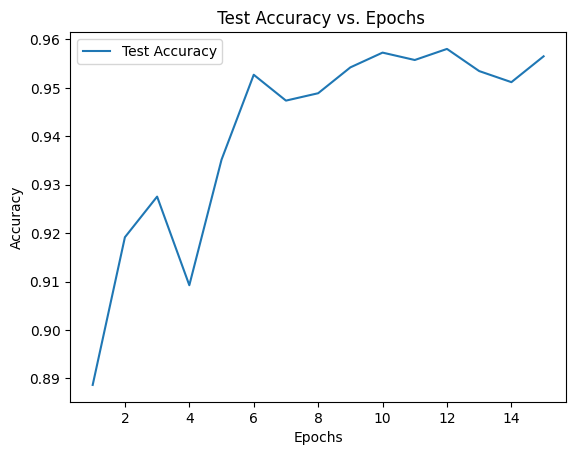

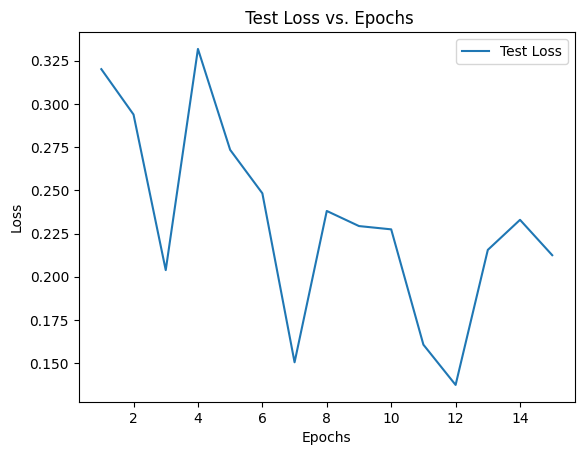

In [56]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)